In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import subplots
from plotly.graph_objs import *
from sklearn import preprocessing

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
# Jackson's Data which can be deleted:
# preTaxIncome  - Average income before taxes in a state.
# postTaxIncome - Average income after taxes in a state.
# taxRates  - Tax rate of the state.

raw_income = pd.read_csv(os.path.join('data', 'Disposal and Total income 2011 - 2018 SAINC50.csv'))

preTaxIncome = raw_income[raw_income.Description.values == "Per capita personal income (dollars) 2/"]
postTaxIncome = raw_income[raw_income.Description.values == "Per capita disposable personal income (dollars) 3/"]

# Drop unneccessary columns.
preTaxIncome = preTaxIncome[["GeoName", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]]
postTaxIncome = postTaxIncome[["GeoName", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]]

# Rename GeoName->State
preTaxIncome.rename(columns = {"GeoName" : "State"}, inplace = True)
postTaxIncome.rename(columns = {"GeoName" : "State"}, inplace = True) 

# Initialized taxRates DF
taxRates = pd.DataFrame(columns = preTaxIncome.columns)
taxRates.State = preTaxIncome.State

# taxRate @ year = (preTax[year] - postTax[year]) / preTax[year]
for columnPre, columnPost in zip(preTaxIncome.columns, postTaxIncome.columns):
    if(columnPre == "State"): continue
    taxRates[columnPre] = (preTaxIncome[columnPre].to_numpy() - postTaxIncome[columnPost].to_numpy()) / preTaxIncome[columnPre].to_numpy()
    
# Melt the year columns into the rows.
preTaxIncome = pd.melt(preTaxIncome, id_vars=['State'], var_name = 'Year', value_name = 'Pre-Tax Income')
postTaxIncome = pd.melt(postTaxIncome, id_vars=['State'], var_name = 'Year', value_name = 'Post-Tax Income')
taxRates = pd.melt(taxRates, id_vars=['State'], var_name = 'Year', value_name = 'Taxes')

# Merge nicely later.
preTaxIncome.Year = preTaxIncome.Year.astype(int)
postTaxIncome.Year = postTaxIncome.Year.astype(int)
taxRates.Year = taxRates.Year.astype(int)

In [4]:
#i stored the csv files in a file named data and this line makes a file path for the .read_csv method
income_csv = os.path.join('data', 'Minimum Wage Data.csv')
qol_csv = os.path.join('data', 'qol_index.csv')
qol_factors = os.path.join('data', 'QOL.xlsx')

#read in the csv files
income_df = pd.read_csv(income_csv)
qol_df = pd.read_csv(qol_csv)
factors = pd.read_excel(qol_factors)

In [5]:
#cleaning the income table
#drop the "Table_Data" and "Footnote" columns
income_df = income_df.drop(columns=['Table_Data', 'Footnote', 'CPI.Average'])

#take only the years after 2011
income_17 = income_df.loc[income_df.Year >= 2011]
income_17['Year'] = income_17['Year'].astype(str)

#find the federal minimums for the year and then remove federal info from table
fed_min = income_17[income_17.State == 'Federal (FLSA)'].reset_index(drop = True)
income_17 = income_17[income_17.State != 'Federal (FLSA)'].reset_index(drop = True)

#need to replace 0s with the federal minimum wage; these are states without a state minimum so federal applies
zero_states = (income_17.loc[(income_17['High.Value'] == 0) & (income_17['Low.Value'] == 0)])
z_idx = zero_states.index
replacing = ['Low.Value','High.Value','High.2018','Low.2018']

#go through each year
for feds in fed_min.index:
    #go through each state at a particular year
    for idx in zero_states.loc[zero_states.Year == fed_min.iloc[feds]['Year']].index:
        #update the 0s in the row to reflect the federal minimum wage at the time
        income_17.loc[idx, replacing] = fed_min.loc[feds].values[2:]

/Users/johngonzalez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
#check to see if it was updated correctly
income_17.iloc[z_idx].head()

,Year,State,High.Value,Low.Value,High.2018,Low.2018
0,2011,Alabama,7.25,7.25,8.07,8.07
19,2011,Louisiana,7.25,7.25,8.07,8.07
25,2011,Mississippi,7.25,7.25,8.07,8.07
42,2011,South Carolina,7.25,7.25,8.07,8.07
44,2011,Tennessee,7.25,7.25,8.07,8.07


In [7]:
#find the years that the state changed the minimum wage
def find_wage_change(df):
    '''
    Finds the years when a state increased its minimum wage.
    '''
    years = df['High.Value'].diff()[df['High.Value'].diff() != 0].index.values
    if len(years) > 1:
        return df.loc[years]['Year'].values[1:]
                                    
changing_years = income_17.groupby('State').apply(find_wage_change)
changed_df = pd.DataFrame(changing_years, columns = ['Years Changed']).dropna()
changed_df.head()

,Years Changed
State,
Alaska,"[2015, 2016, 2017]"
Arizona,"[2012, 2013, 2014, 2015, 2017]"
Arkansas,"[2015, 2016, 2017]"
California,"[2014, 2016]"
Colorado,"[2012, 2013, 2014, 2015, 2016, 2017]"


In [8]:
years_lst = []
years_list = [2012, 2013,2014, 2015, 2016, 2017]
# for each year, find which states changed their minimum wage
for year in years_list:
    for state, years_changed in changed_df.iterrows():
        print(state, year)
        year = str(year)
        if year in years_changed.values[0]:
            tmp_dict = {}
            tmp_dict.update({'Year':year, 'States': state})
            years_lst.append(tmp_dict)
            
years_changed_df = pd.DataFrame(years_lst).groupby("Year")['States'].apply(list)         
years_changed_df = years_changed_df.to_frame()
years_changed_df

Alaska 2012
Arizona 2012
Arkansas 2012
California 2012
Colorado 2012
Connecticut 2012
Delaware 2012
District of Columbia 2012
Florida 2012
Guam 2012
Hawaii 2012
Maine 2012
Maryland 2012
Massachusetts 2012
Michigan 2012
Minnesota 2012
Missouri 2012
Montana 2012
Nebraska 2012
New Jersey 2012
New York 2012
Ohio 2012
Oregon 2012
Rhode Island 2012
South Dakota 2012
Vermont 2012
Washington 2012
West Virginia 2012
Alaska 2013
Arizona 2013
Arkansas 2013
California 2013
Colorado 2013
Connecticut 2013
Delaware 2013
District of Columbia 2013
Florida 2013
Guam 2013
Hawaii 2013
Maine 2013
Maryland 2013
Massachusetts 2013
Michigan 2013
Minnesota 2013
Missouri 2013
Montana 2013
Nebraska 2013
New Jersey 2013
New York 2013
Ohio 2013
Oregon 2013
Rhode Island 2013
South Dakota 2013
Vermont 2013
Washington 2013
West Virginia 2013
Alaska 2014
Arizona 2014
Arkansas 2014
California 2014
Colorado 2014
Connecticut 2014
Delaware 2014
District of Columbia 2014
Florida 2014
Guam 2014
Hawaii 2014
Maine 2014
Maryla

,States
Year,
2012,"[Arizona, Colorado, Florida, Montana, Ohio, Or..."
2013,"[Arizona, Colorado, Florida, Missouri, Montana..."
2014,"[Arizona, California, Colorado, Connecticut, D..."
2015,"[Alaska, Arizona, Arkansas, Colorado, Connecti..."
2016,"[Alaska, Arkansas, California, Colorado, Conne..."
2017,"[Alaska, Arizona, Arkansas, Colorado, Connecti..."


In [9]:
#cleaning of the QOL table
#some general cleaning of the columns for easier handling
qol_df = qol_df.drop(columns = ['FIPS', 'EASI Quality of Life Index, 2018', 'EASI Quality of Life Index, 2019'], axis = 1)
qol_df.columns = qol_df.columns.str.replace('EASI Quality of Life Index, ', '')
qol_17 = qol_df.copy()

#transposing the qol table into a format that's more aligned with the income table
transpose_qol = qol_17.melt('Name')
transpose_qol.columns = ['State', 'Year' , 'QOL Index']
transpose_qol['Year'] = transpose_qol['Year'].astype(int)
transpose_qol['QOL Index'] = transpose_qol['QOL Index'].astype(int)

#find the states that weren't included in both and remove from income_17
no_qol = np.setdiff1d(np.union1d(income_17['State'], transpose_qol['State']), np.intersect1d(income_17['State'], transpose_qol['State']))
income_17 = income_17[~income_17['State'].isin(no_qol)]
income_17.Year = income_17.Year.astype(int)
transpose_qol.Year = transpose_qol.Year.astype(int)
income_qol = income_17.merge(transpose_qol, on = ['State', 'Year'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a19980cd0>,
      dtype=object)

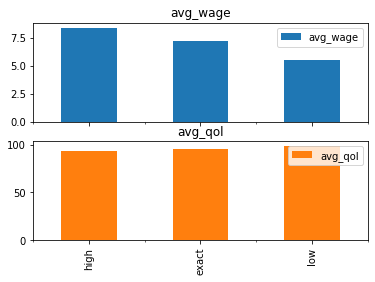

In [10]:
high_min = income_qol[income_qol['High.Value'] > 7.25]
exact_min = income_qol[income_qol['High.Value'] == 7.25]
low_min = income_qol[income_qol['High.Value'] < 7.25]

avg_qol_high = high_min.describe()['QOL Index']['mean'].round(2)
avg_qol_exact = exact_min.describe()['QOL Index']['mean'].round(2)
avg_qol_low = low_min.describe()['QOL Index']['mean'].round(2)

avg_wage_high = high_min.describe()['High.Value']['mean'].round(2)
avg_wage_exact = exact_min.describe()['High.Value']['mean'].round(2)
avg_wage_low = low_min.describe()['High.Value']['mean'].round(2)

avg_wages = pd.DataFrame({
    'avg_wage' : [avg_wage_high, avg_wage_exact, avg_wage_low],
    'avg_qol' : [avg_qol_high, avg_qol_exact, avg_qol_low]}, 
    index = ['high', 'exact', 'low'],)

avg_wages.plot.bar(subplots=True)
#print('For states with a minimum wage higher than the federal minimum, their average minimum wage was ' + str(avg_wage_high) 
#      + ' and their average QOL was ' + str(avg_qol_high))
#print('For states with the federal minimum, their average QOL was ' + str(avg_qol_exact))
#print('For states with a minimum wage lower than the federal minimum, their average minimum wage was ' + str(avg_wage_low) 
#      + ' and their average QOL was ' + str(avg_qol_low))

In [11]:
def find_qol_wage(df):
    '''
    Finds the highest minimum wage and QOL index.
    Finds the lowest minimum wage and QOL index.
    '''
    high_qol = df.loc[df['QOL Index']== max(df['QOL Index'])]
    high_income = df.loc[df['High.Value']== max(df['High.Value'])]
    low_qol = df.loc[df['QOL Index']== min(df['QOL Index'])]
    low_income = df.loc[df['High.Value']== min(df['High.Value'])]
    return [high_qol, high_income, low_qol, low_income]


In [12]:
#use the find_qol_wage function to find the highest/lowest minimum wage/QOL by year.
test = income_qol.groupby('Year').apply(find_qol_wage)
for year in test:
    print(year[0]['Year'].values[0])
    print('The state with the highest minimum wage was ' + (year[1]['State'].values[0]) + ' - $'+ str(year[1]['High.Value'].values[0]))
    print('The state with the highest QOL was ' + (year[0]['State'].values[0]) + ' - '+ str(year[0]['QOL Index'].values[0]))
    print('The state with the lowest minimum wage was ' + (year[3]['State'].values[0]) + ' - $'+ str(year[3]['High.Value'].values[0]))
    print('The state with the lowest QOL was ' + (year[2]['State'].values[0]) + ' - '+ str(year[2]['High.Value'].values[0]))
    print('\n')

2011
The state with the highest minimum wage was Washington - $8.67
The state with the highest QOL was California - 155
The state with the lowest minimum wage was Georgia - $5.15
The state with the lowest QOL was Alaska - 7.75


2012
The state with the highest minimum wage was Washington - $9.04
The state with the highest QOL was California - 153
The state with the lowest minimum wage was Georgia - $5.15
The state with the lowest QOL was Alaska - 7.75


2013
The state with the highest minimum wage was Washington - $9.19
The state with the highest QOL was California - 153
The state with the lowest minimum wage was Georgia - $5.15
The state with the lowest QOL was Alaska - 7.75


2014
The state with the highest minimum wage was District of Columbia - $9.5
The state with the highest QOL was California - 153
The state with the lowest minimum wage was Georgia - $5.15
The state with the lowest QOL was Alaska - 7.75


2015
The state with the highest minimum wage was District of Columbia - $10

In [13]:
qol_factors = os.path.join('data', 'QOL.xlsx')
factors = pd.read_excel(qol_factors)

factor_columns = [
    'EASI Total Crime Index',
    'Median Household Income',
    '% Education Attainment, High School (Pop 25+)',
    "% Education Attainment, Bachelor's Degree (Pop 25+)",
    'Culture Index',
    'Mortality Index (All Causes)'
]

#some of the columns had 2019 in them; our minimum wage dataset only goes up to 2017
new_cols = [col for col in factors.columns if '2019' not in col]
factors = factors[new_cols]

#transpose the original table to be a similar format with our other dataframes
factors_combined = income_qol[['State','Year']]
factors_combined['Year'] = factors_combined['Year'].astype(int)
for factor_col in factor_columns:
    temp_df = factors[['Name'] + [col for col in factors.columns if factor_col in col]]
    temp_df.columns = ['State', '2017', '2016', '2015', '2014', '2013', '2012', '2011']
    transposed = temp_df.melt(['State'], var_name = 'Year', value_name = factor_col)
    transposed.Year = transposed.Year.astype(int)
    factors_combined = factors_combined.merge(transposed, on = ['State', 'Year'])
    
factors_combined.columns = [
    'State',
    'Year',
    'Crime Idx',     
    'Household Income',
    '%HS Attn',
    '%BA/BS Attn',            
    'Culture Idx',
    'Mortality Idx'
]

# Tax rate
factors_combined = factors_combined.merge(taxRates, on=['Year', 'State'])

# Use BEA income stats.
# factors_combined = factors_combined.merge(preTaxIncome, on=['Year', 'State'])
# factors_combined = factors_combined.drop('Household Income', axis=1)

/Users/johngonzalez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
factors_combined.head()

,State,Year,Crime Idx,Household Income,%HS Attn,%BA/BS Attn,Culture Idx,Mortality Idx,Taxes
0,Alabama,2011,109,47557,0.316003,0.140403,23,85,0.089608
1,Alaska,2011,115,72404,0.282370,0.171444,96,4,0.081447
2,Arizona,2011,81,57924,0.254460,0.165372,88,100,0.093114
3,Arkansas,2011,120,44634,0.350735,0.129070,12,123,0.090807
4,California,2011,74,67085,0.216167,0.191133,135,46,0.120121


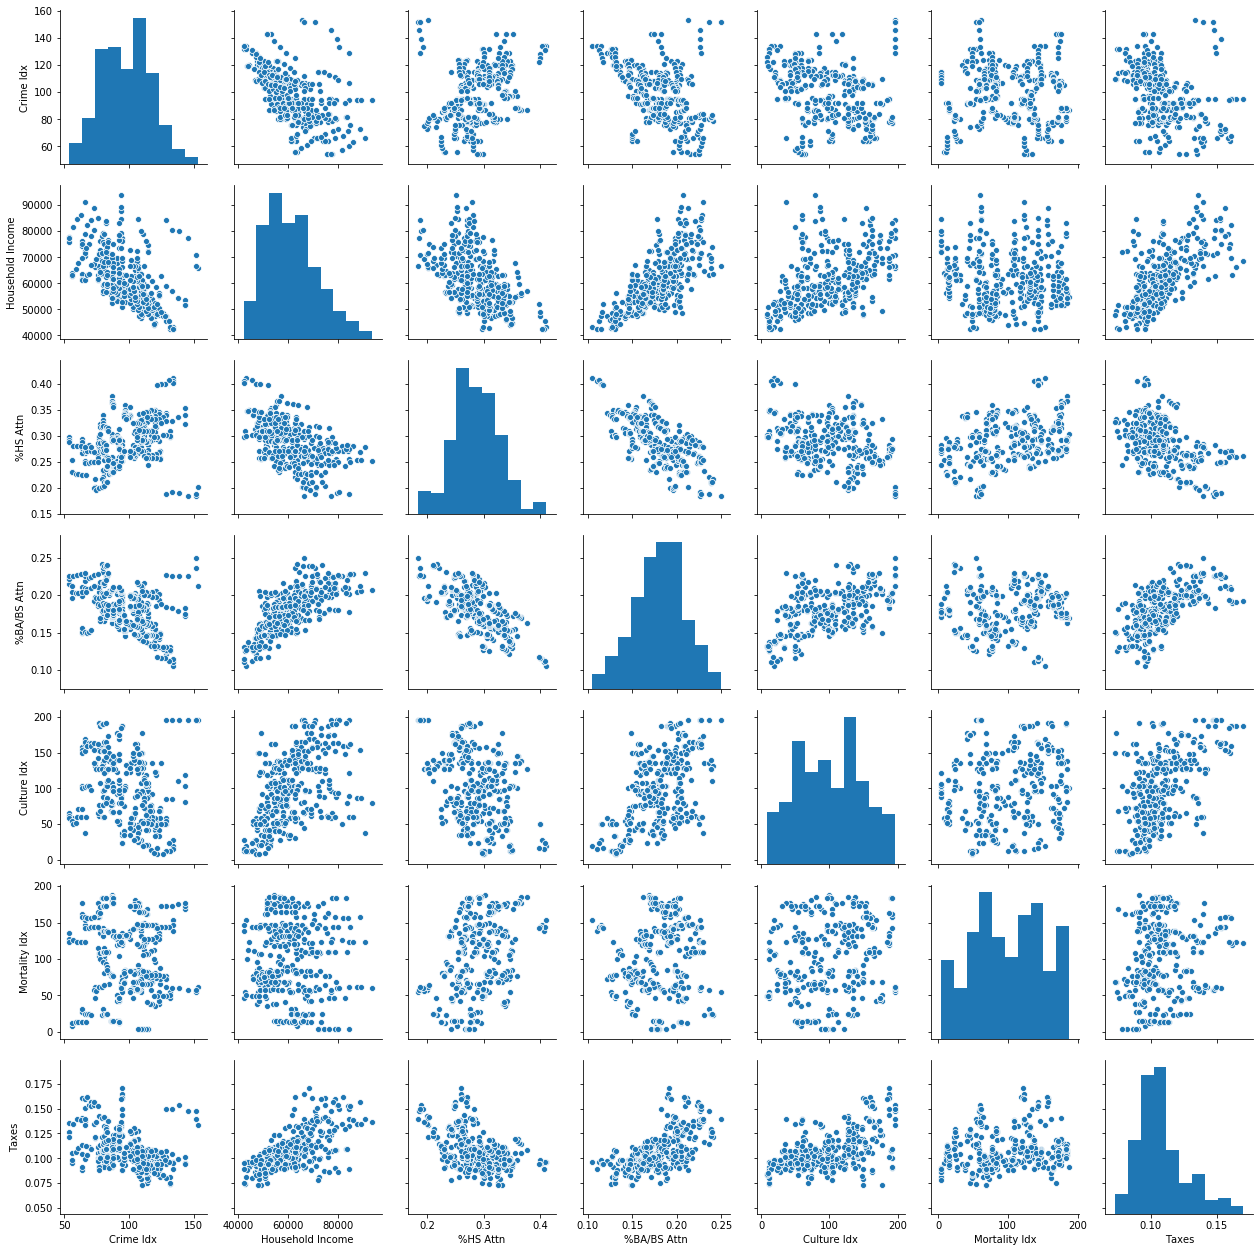

In [15]:
selected = [col for col in factors_combined.columns if col != 'State' and col !='Year']
sns.pairplot(factors_combined[selected])

In [16]:
factors_combined.corr()

,Year,Crime Idx,Household Income,%HS Attn,%BA/BS Attn,Culture Idx,Mortality Idx,Taxes
Year,1.000000,-0.039791,0.349586,-0.105534,0.085453,-0.007401,-0.001106,0.236959
Crime Idx,-0.039791,1.000000,-0.535102,0.343752,-0.434027,-0.273914,-0.001598,-0.383169
Household Income,0.349586,-0.535102,1.000000,-0.522465,0.719924,0.493812,-0.040946,0.655335
%HS Attn,-0.105534,0.343752,-0.522465,1.000000,-0.684026,-0.364252,0.355378,-0.456856
%BA/BS Attn,0.085453,-0.434027,0.719924,-0.684026,1.000000,0.534359,0.100442,0.606262
Culture Idx,-0.007401,-0.273914,0.493812,-0.364252,0.534359,1.000000,0.190226,0.549911
Mortality Idx,-0.001106,-0.001598,-0.040946,0.355378,0.100442,0.190226,1.000000,0.148476
Taxes,0.236959,-0.383169,0.655335,-0.456856,0.606262,0.549911,0.148476,1.000000


In [17]:
factors_combined.Year = factors_combined.Year.astype(int)
income_17.Year = income_17.Year.astype(int)
income_factors = factors_combined.merge(income_17[['Year','State','High.Value']], on=['Year','State'])

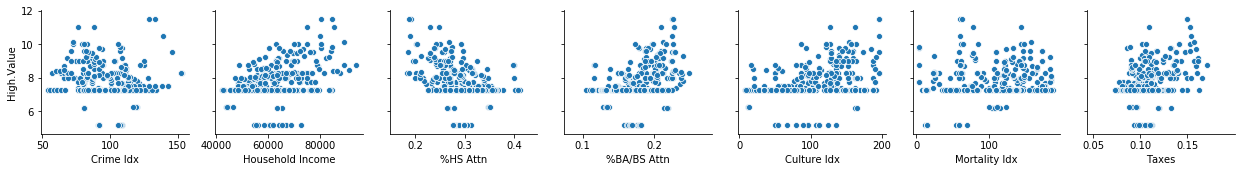

In [18]:
sns.pairplot(income_factors[selected + ['High.Value']], y_vars = ['High.Value'], x_vars = selected)

In [19]:
income_factors.corr()

,Year,Crime Idx,Household Income,%HS Attn,%BA/BS Attn,Culture Idx,Mortality Idx,Taxes,High.Value
Year,1.000000,-0.039791,0.349586,-0.105534,0.085453,-0.007401,-0.001106,0.236959,0.337562
Crime Idx,-0.039791,1.000000,-0.535102,0.343752,-0.434027,-0.273914,-0.001598,-0.383169,-0.128105
Household Income,0.349586,-0.535102,1.000000,-0.522465,0.719924,0.493812,-0.040946,0.655335,0.426743
%HS Attn,-0.105534,0.343752,-0.522465,1.000000,-0.684026,-0.364252,0.355378,-0.456856,-0.367112
%BA/BS Attn,0.085453,-0.434027,0.719924,-0.684026,1.000000,0.534359,0.100442,0.606262,0.361491
Culture Idx,-0.007401,-0.273914,0.493812,-0.364252,0.534359,1.000000,0.190226,0.549911,0.394279
Mortality Idx,-0.001106,-0.001598,-0.040946,0.355378,0.100442,0.190226,1.000000,0.148476,0.176509
Taxes,0.236959,-0.383169,0.655335,-0.456856,0.606262,0.549911,0.148476,1.000000,0.420214
High.Value,0.337562,-0.128105,0.426743,-0.367112,0.361491,0.394279,0.176509,0.420214,1.000000


In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = income_factors.rename(columns={'Crime Idx': 'crime', 
                                    'Household Income': 'income', 
                                    '%HS Attn': 'hs', 
                                    '%BA/BS Attn': 'bs',
                                    'Culture Idx': 'culture',
                                    'Mortality Idx': 'mortality',
                                    'High.Value': 'wages'})

In [21]:
pred_income = smf.ols(formula='income ~ bs', data=df)
res_income = pred_income.fit()

pred_income_wage = smf.ols(formula='income ~ bs + wages', data=df)
res_income_wage = pred_income_wage.fit()
print(res_income.summary(), '\n', '\n' ,res_income_wage.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     382.0
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           2.90e-58
Time:                        18:39:09   Log-Likelihood:                -3677.2
No. Observations:                 357   AIC:                             7358.
Df Residuals:                     355   BIC:                             7366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.324e+04   2498.906      5.299      0.0

In [22]:
pred_bs = smf.ols(formula='bs ~ culture', data=df)
res_bs = pred_bs.fit()

pred_bs_wage = smf.ols(formula='bs ~ culture + wages', data=df)
res_bs_wage = pred_bs_wage.fit()
print(res_bs.summary(), '\n', '\n' ,res_bs_wage.summary())

                            OLS Regression Results                            
Dep. Variable:                     bs   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     141.9
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           9.48e-28
Time:                        18:39:09   Log-Likelihood:                 830.31
No. Observations:                 357   AIC:                            -1657.
Df Residuals:                     355   BIC:                            -1649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1499      0.003     51.885      0.0

In [23]:
pred_hs = smf.ols(formula='hs ~ bs', data=df)
res_hs = pred_hs.fit()

pred_hs_wage = smf.ols(formula='hs ~ bs + wages', data=df)
res_hs_wage = pred_hs_wage.fit()
print(res_hs.summary(), '\n', '\n', res_hs_wage.summary())

                            OLS Regression Results                            
Dep. Variable:                     hs   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     312.2
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           1.43e-50
Time:                        18:39:09   Log-Likelihood:                 738.93
No. Observations:                 357   AIC:                            -1474.
Df Residuals:                     355   BIC:                            -1466.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4718      0.011     44.495      0.0

In [24]:
pred_hs2 = smf.ols(formula='hs ~ income', data=df)
res_hs2 = pred_hs2.fit()

pred_hs_wage2 = smf.ols(formula='hs ~ income + wages', data=df)
res_hs_wage2 = pred_hs_wage2.fit()
print(res_hs2.summary(), '\n', '\n', res_hs_wage2.summary())

                            OLS Regression Results                            
Dep. Variable:                     hs   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     133.3
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           2.14e-26
Time:                        18:39:09   Log-Likelihood:                 683.21
No. Observations:                 357   AIC:                            -1362.
Df Residuals:                     355   BIC:                            -1355.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4164      0.011     36.538      0.0

In [25]:
pred_crime = smf.ols(formula='crime ~ income', data=df)
res_crime = pred_crime.fit()

pred_crime_wage = smf.ols(formula='crime ~ income + wages', data=df)
res_crime_wage = pred_crime_wage.fit()
print(res_crime.summary(), '\n', '\n', res_crime_wage.summary())

                            OLS Regression Results                            
Dep. Variable:                  crime   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     142.4
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           7.77e-28
Time:                        18:39:09   Log-Likelihood:                -1511.9
No. Observations:                 357   AIC:                             3028.
Df Residuals:                     355   BIC:                             3036.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    160.9648      5.335     30.170      0.0

In [26]:
pred_crime = smf.ols(formula='crime ~ income', data=df)
res_crime = pred_crime.fit()

pred_crime_wage = smf.ols(formula='crime ~ income + wages', data=df)
res_crime_wage = pred_crime_wage.fit()
print(res_crime.summary(), '\n', '\n', res_crime_wage.summary())

                            OLS Regression Results                            
Dep. Variable:                  crime   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     142.4
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           7.77e-28
Time:                        18:39:09   Log-Likelihood:                -1511.9
No. Observations:                 357   AIC:                             3028.
Df Residuals:                     355   BIC:                             3036.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    160.9648      5.335     30.170      0.0

In [27]:
#dictionary with state and corresponding code was retrieved from:
#https://gist.github.com/rogerallen/1583593

state_code = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    #'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    #'Palau': 'PW',
    'Pennsylvania': 'PA',
    #'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    #'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

st_code = []

for state in income_qol['State']:
    st_code.append(state_code[state])

#add column with corresponding state abbreviations
codes = np.asarray(st_code)
income_factors['Code'] = codes

In [28]:
#color codes retrieved from:
#http://colorbrewer2.org/#type=sequential&scheme=Blues&n=6

#shades of green
greens = [[0.0, '#edf8e9'],[0.2, '#c7e9c0'],[0.4, '#a1d99b'], 
        [0.6, '#74c476'],[0.8, '#31a354'],[1.0, '#006d2c']]

#shades of blue
blues = [[0.0, '#eff3ff'],[0.2, '#c6dbef'],[0.4, '#9ecae1'], 
        [0.6, '#6baed6'],[0.8, '#3182bd'],[1.0, '#08519c']]

# shades of red
reds = [[0.0,'#fee5d9'],[0.2,'#fcbba1'],[0.4,'#fc9272'],
        [0.6,'#fb6a4a'],[0.8,'#de2d26'],[1.0,'#a50f15']]

# light and dark orange
orange = [[0.0, '#feedde'],[1.0, '#fd8d3c']]

In [29]:
# I used this source as a guide to create the choropleth maps
# https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu
# https://plot.ly/python/reference/#choropleth

# class MinWageMap:
#     """
#     This is a class to create choropleth maps.
    
#     Attributes:
#         year (str): Year selected
#         color (list): Color range for map
#         var (str): Variable that will be plotted onto the map
#         column (str): Name of column representing "var"
#     """
#     def __init__(self, year, color, var, column):
#         """
#         The constructor for MinWageMap class.
        
#         Parameters:
#             year (str): Year selected
#             color (list): Color range for map
#             var (str): Variable that will be plotted onto the map
#             column (str): Name of column representing "var"
#         """
#         self.year = int(year)
#         self.color = color
#         self.var = var
#         self.column = column
        
#     def select_year(self):
#         """Selects a specific year and creates a new DataFrame attribute."""
#         self.df_map = income_factors[income_factors['Year']==self.year]
    
#     def find_mean(self, var_mean):
#         """
#         Uses the 'describe' method to get the mean of the variable selected. 
#         Assigns the mean to the 'avg' class attribute.
        
#         Parameters:
#             var_mean (str): Column that will be used to calculate mean
#         """
#         stats = self.df_map.describe()
#         self.avg = round(stats.loc['mean',var_mean], 2)
        
#     def normalize_df(self):
#         """
#         Removes columns with strings, normalizes the resulting dataframe, then adds
#         the columns back
        
#         Parameters:
#             norm_df (DataFrame): Pandas DataFrame to be normalized
#         """
#         self.norm_df = self.df_map.drop(['State','Year','Code'],axis=1)
        
#         # I used this source as a guide to normalize the values in the columns:
#         # https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
#         x = self.norm_df.loc[:]
#         mms = preprocessing.MinMaxScaler()
#         x_scaled = mms.fit_transform(x)
#         self.normed_df = pd.DataFrame(x_scaled, columns=self.norm_df.columns)
            
#         self.normed_df.loc[:,'Year'] = np.array(self.df_map.loc[:,'Year'])
#         self.normed_df.loc[:,'Code'] = np.array(self.df_map.loc[:,'Code'])
    
#     def col_str(self):
#         """Converts all the values inside the DataFrame to string type."""
#         for col in list(self.df_map.columns):
#             self.df_map[col] = self.df_map[col].astype(str)
    
#     def popup_text(self):
#         """Creates a new column with text for the popup window."""
#         self.df_map.loc[:,'text'] = self.df_map['State'] + '<br>' + \
#                             self.var + ' Level: ' + self.df_map[self.column] + '<br>' + \
#                             'Average '+self.var+' Level: ' + str(self.avg)
    
#     def input_data(self, map_title, x_bar, label):
#         """
#         Input the data to plot on the map.
        
#         Parameters:
#             map_title (str): Title for the map
#             x_bar (int or float): x-position for the color bar.
#             label (bool): Choose to show the values on the color bar
            
#         Returns:
#             fig (dict): Dictionary that contains all the necessesary information to plot map
#         """
#         data = dict(
#                     type='choropleth',
#                     locations = self.df_map.loc[:,'Code'],
#                     z = self.df_map.loc[:,self.column],
#                     zauto=False,
#                     locationmode = 'USA-states',
#                     autocolorscale=False,
#                     colorscale = self.color,
#                     name='',
#                     text = self.df_map['text'],
#                     colorbar = dict(title = map_title,
#                                     showticklabels=label,
#                                     tickmode='auto',
#                                     x=x_bar, 
#                                     titleside='right')
#                     )
#         layout = dict(
#                     geo=dict(
#                             scope='usa',
#                             projection={'type':'albers usa'},
#                             showlakes=False
#                             ))
#         fig = dict(data=data, layout=layout)
        
#         return fig

In [30]:
def find_mean(var_mean):
    """
    Uses the 'describe' method to get the mean of the variable selected. 
    Assigns the mean to the 'avg' class attribute.

    Parameters:
        var_mean (str): Column that will be used to calculate mean.
        
    Returns:
        mean (str): Returns the calculated mean as a string.
    """
    stats = df_map.describe()
#     mean = round(stats.loc['mean',var_mean], 2)
    return round(stats.loc['mean',var_mean], 2)

def normalize_df():
    """
    Removes df_map columns with strings, normalizes the resulting dataframe, then adds
    the columns back.

    Returns:
        norm_df (DataFrame): Normalized pandas DataFrame
    """
    # I used this source as a guide to normalize the values in the columns:
    # https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
    x = df_map.loc[:,'Crime Idx':'High.Value']
    mms = preprocessing.MinMaxScaler()
    x_scaled = mms.fit_transform(x)
    normed_df = pd.DataFrame(x_scaled, columns=df_map.loc[:,'Crime Idx':'High.Value'].columns)

    # Add 'Year' column back in
    normed_df.loc[:,'Year'] = df_map.loc[:,'Year'].values[0]
    
    # Add 'Code' column back in
    i=0
    for code in df_map.loc[:,'Code']:
        normed_df.loc[i,'Code'] = code
        i+=1

    return normed_df

def popup_text():
    """Creates a new column with text for the popup window."""
    for index,row in df_map.iterrows():
        df_map.loc[index,('text')] = df_map.loc[index,'State']+'<br>'+\
                                    var+' Level: '+str(df_map.loc[index,column])+'<br>'+ \
                                    'Average '+var+' Level: '+str(mean)


        
def input_data(color, map_title, label, x_bar):
    """
    Input the data to plot on the map.

    Parameters:
        color (list): Range of colors for the map
        map_title (str): Title for the map
        label (bool): Choose to show the values on the color bar
        x_bar (int or float): x-position for the color bar.

    Returns:
        fig (dict): Dictionary that contains all the necessesary information to plot map
    """
    data = dict(
                type='choropleth',
                locations = list(df_map['Code']),
                z = df_map[column],
                zauto=False,
                locationmode = 'USA-states',
                autocolorscale=False,
                colorscale = color,
                name='',
                text = df_map['text'],
                colorbar = dict(title = map_title,
                                showticklabels=label,
                                tickmode='auto',
                                x=x_bar, 
                                titleside='right')
                )
    layout = dict(
                geo=dict(
                        scope='usa',
                        projection={'type':'albers usa'},
                        showlakes=False
                        ))
    fig = dict(data=data, layout=layout)

    return fig

In [31]:
income_list=[]
crime_list=[]
var='Household Income'
column='Household Income'

for year_selected in range(2011,2018):
    df_map = income_factors[income_factors['Year']==year_selected]
    
    mean=find_mean('Crime Idx')
    normed_df=normalize_df()
    df_str = df_map.astype(str)
    popup_text()
    
    if year_selected%2==0:
        income_list.append(input_data(blues,'Household Income',True,-.05))
        crime_list.append(input_data(reds,'Crime',True,0.95))
    else:
        income_list.append(input_data(blues,'',False,-.05))
        crime_list.append(input_data(reds,'',False,0.95))
        
    
    

/Users/johngonzalez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/johngonzalez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/johngonzalez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [32]:
df_map

,State,Year,Crime Idx,Household Income,%HS Attn,%BA/BS Attn,Culture Idx,Mortality Idx,Taxes,High.Value,Code,text
306,Alabama,2017,104,56896,0.305657,0.147575,27,79,0.098673,7.25,AL,Alabama<br>Household Income Level: 56896<br>Av...
307,Alaska,2017,107,84509,0.274127,0.178002,121,4,0.088795,9.80,AK,Alaska<br>Household Income Level: 84509<br>Ave...
308,Arizona,2017,83,63057,0.241350,0.173862,87,85,0.101376,10.00,AZ,Arizona<br>Household Income Level: 63057<br>Av...
309,Arkansas,2017,111,52876,0.345063,0.138507,19,106,0.098194,8.50,AR,Arkansas<br>Household Income Level: 52876<br>A...
310,California,2017,81,74950,0.202745,0.198657,121,64,0.141499,10.00,CA,California<br>Household Income Level: 74950<br...
311,Colorado,2017,83,73812,0.210880,0.240262,110,24,0.126394,9.30,CO,Colorado<br>Household Income Level: 73812<br>A...
312,Connecticut,2017,73,88947,0.268500,0.212301,154,157,0.156537,10.10,CT,Connecticut<br>Household Income Level: 88947<b...
313,Delaware,2017,84,76682,0.314731,0.181804,112,110,0.118491,8.25,DE,Delaware<br>Household Income Level: 76682<br>A...
314,District of Columbia,2017,129,84461,0.188113,0.226900,196,62,0.149958,11.50,DC,District of Columbia<br>Household Income Level...
315,Florida,2017,88,61846,0.292780,0.175749,96,184,0.100503,8.10,FL,Florida<br>Household Income Level: 61846<br>Av...


In [33]:
# income_list=[]
# crime_list=[]

# for year_selected in range(2011,2018):
#     # append data to income_list to plot household income column of maps
#     income_map = MinWageMap(year_selected, blues, 'Household Income', 'Household Income')
#     income_map.select_year()
#     income_map.find_mean('Household Income')
#     income_map.normalize_df()
#     income_map.col_str()
#     income_map.popup_text()
    
#     # append data to crime_list to plot crime column of maps
#     crime_map = MinWageMap(year_selected, reds, 'Crime', 'Crime Idx')
#     crime_map.select_year()
#     crime_map.find_mean('Crime Idx')
#     crime_map.normalize_df()
#     crime_map.col_str()
#     crime_map.popup_text()

#     if year_selected%2==0:
#         income_list.append(income_map.input_data('Household Income',-.05,True))
#         crime_list.append(crime_map.input_data('Crime',0.95,True))
#     else:
#         income_list.append(income_map.input_data('',-.05,False))
#         crime_list.append(crime_map.input_data('',0.95,False))

In [34]:
# create income map objects
income_2011 = go.Figure(income_list[0])
income_2012 = go.Figure(income_list[1])
income_2013 = go.Figure(income_list[2])
income_2014 = go.Figure(income_list[3])
income_2015 = go.Figure(income_list[4])
income_2016 = go.Figure(income_list[5])
income_2017 = go.Figure(income_list[6])

# create crime map objects
crime_2011 = go.Figure(crime_list[0])
crime_2012 = go.Figure(crime_list[1])
crime_2013 = go.Figure(crime_list[2])
crime_2014 = go.Figure(crime_list[3])
crime_2015 = go.Figure(crime_list[4])
crime_2016 = go.Figure(crime_list[5])
crime_2017 = go.Figure(crime_list[6])

In [35]:
# create subplots to place the maps in
# https://plot.ly/python/subplots/
fig0 = subplots.make_subplots(
                            rows=2,cols=2,
                            specs=[[{"type":"choropleth"},{"type":"choropleth"}],
                                   [{"type":"choropleth"},{"type":"choropleth"}]],
                            subplot_titles=('2011','2011',
                                            '2012','2012')
                            )

fig1 = subplots.make_subplots(
                            rows=2,cols=2,
                            specs=[[{"type":"choropleth"},{"type":"choropleth"}],
                                   [{"type":"choropleth"},{"type":"choropleth"}]],
                            subplot_titles=('2013','2013',
                                            '2014','2014')
                            )

fig2 = subplots.make_subplots(
                            rows=3,cols=2,
                            specs=[[{"type":"choropleth"},{"type":"choropleth"}],
                                   [{"type":"choropleth"},{"type":"choropleth"}],
                                   [{"type":"choropleth"},{"type":"choropleth"}]],
                            subplot_titles=('2015','2015',
                                            '2016','2016',
                                            '2017','2017')
                            )

In [36]:
# add income maps to subplot (first column)
fig0.append_trace(income_2011['data'][0], 1, 1)
fig0.append_trace(income_2012['data'][0], 2, 1)

fig1.append_trace(income_2013['data'][0], 1, 1)
fig1.append_trace(income_2014['data'][0], 2, 1)

fig2.append_trace(income_2015['data'][0], 1, 1)
fig2.append_trace(income_2016['data'][0], 2, 1)
fig2.append_trace(income_2017['data'][0], 3, 1)

# add crime maps to subplot (second column)
fig0.append_trace(crime_2011['data'][0], 1, 2)
fig0.append_trace(crime_2012['data'][0], 2, 2)

fig1.append_trace(crime_2013['data'][0], 1, 2)
fig1.append_trace(crime_2014['data'][0], 2, 2)

fig2.append_trace(crime_2015['data'][0], 1, 2)
fig2.append_trace(crime_2016['data'][0], 2, 2)
fig2.append_trace(crime_2017['data'][0], 3, 2)

In [37]:
# change scope to USA
# https://plot.ly/python/mixed-subplots/
fig0.update_geos(scope='usa')
fig1.update_geos(scope='usa')
fig2.update_geos(scope='usa')

# add title
# https://plot.ly/python/choropleth-maps/
fig0.update_layout(title_text='Household Income and Crime Over the Years (2011-2012)')
fig1.update_layout(title_text='Household Income and Crime Over the Years (2013-2014)')
fig2.update_layout(title_text='Household Income and Crime Over the Years (2015-2017)')

print()

In [38]:
fig0.show()
fig1.show()
fig2.show()

In [39]:
# #choose specific state
# state_chosen = 'Ohio'

# #create dataframe with only the chosen state's information
# state_df = income_factors[income_factors['State'] == state_chosen]
# #drop the "state" and "year" column to normalize resulting data
# norm_df = state_df.drop(['State','Year','Code','High.Value'],axis=1)

In [40]:
# #to normalize the values in the columns, I used this source as a guide:
# #https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

# #normalize norm_df
# x = norm_df.values
# mms = preprocessing.MinMaxScaler()
# x_scaled = mms.fit_transform(x)

# state_norm = pd.DataFrame(x_scaled, columns=norm_df.columns)

In [41]:
# #add year column from state_df to state_norm
# state_norm['Year'] = list(map(int, state_df['Year']))

In [42]:
# state_norm

In [43]:
# #this source was used as a guide to plot multiple lines:
# #https://python-graph-gallery.com/122-multiple-lines-chart/

# plt.plot( 'Year', 'Household Income', data=state_norm, marker='', color='green', linewidth=2)
# plt.plot( 'Year', 'Taxes', data=state_norm, marker='', color='red', linewidth=2)
# plt.plot( 'Year', 'Crime Idx', data=state_norm, marker='', color='olive', linewidth=2)
# #plt.plot( 'Year', '%HS Attn', data=state_norm, marker='', color='orange', linewidth=2, linestyle='dashed')
# #plt.plot( 'Year', 'High.Value', data=state_norm, marker='', color='pink', linewidth=2)
# #plt.legend()

In [44]:
# #I used this source as a guide to create the line plot
# #https://python-graph-gallery.com/125-small-multiples-for-line-chart

# #initialize the figure
# plt.style.use('seaborn-darkgrid')

# #create a color palette
# palette = plt.get_cmap('Dark2')

In [45]:
# place=0
# for column in state_norm.drop(['Year'], axis=1):
#     place+=1
    
#     #choose the spot for the plot
#     plt.subplot(3, 2, place)
    
#     #plot the data from the other columns
#     for val in state_norm.drop('Year', axis=1):
#         plt.plot(state_norm['Year'], state_norm[val], marker='',
#                  color='grey', linewidth=0.6, alpha=0.3)
    
#     plt.plot(state_norm['Year'], state_norm[column], marker='',
#             color=palette(place), linewidth=2.4, alpha=0.9, label=column)
    
#     #set limits
#     plt.xlim(2011,2017)
#     plt.ylim(-0.05,1.06)
    
#     #remove ticks 
#     if place in range(1,5):
#         plt.tick_params(labelbottom=False)
#     if place not in [1,3,5]:
#         plt.tick_params(labelleft=False)
        
#     #title placement
#     plt.title(column, loc='left', fontsize=10, 
#               fontweight=6, color=palette(place))
    

# #title
# plt.suptitle('How ' + state_chosen + ' has been doing', fontsize=13, fontweight=0,
#             color='black', style='italic', y=1)

# plt.text(2010.4, -0.38, 'Year', ha='center', va='center')
# plt.text(2002.7, 1.8, 'Standardized data', ha='center', 
#          va='center', rotation='vertical')
